In [1]:
!pip install ortools

# **🩺 Nurse Rostering Problem**
### **Optimizing Shift Assignments Using OR-Tools**
Adapted from Google OR-Tools Scheduling Guide:  
🔗 [Google OR-Tools - Employee Scheduling](https://developers.google.com/optimization/scheduling/employee_scheduling)

---

## **📌 Problem Overview**
The **Nurse Rostering Problem** is a **Binary Integer Programming Problem** where we assign **nurses to shifts** while ensuring:
1. **Staffing requirements are met** across time periods.
2. **Each nurse works at most one shift per day**.
3. **Fair workload distribution** (minimum and maximum shift constraints).
4. **Nurse preferences are considered** for optimized scheduling.

---

## **🛠️ Step 1: Install and Import Dependencies**

In [2]:
from ortools.sat.python import cp_model
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



## **📅 Step 2: Define Problem Parameters**
To solve the **Nurse Rostering Problem**, we first define the **core scheduling parameters**:

- **Number of Nurses**: The total number of available nurses.
- **Number of Shifts per Day**: The shifts that need to be filled.
- **Number of Days**: The scheduling period (e.g., one week).
- **Nurse and Shift Labels**: Used for easier identification in dataframes and visualization.

We also input the schedule requirements and the mapping of hourly time periods to shifts here.

In [3]:

num_nurses = 50  # Number of nurses
num_shifts = 5   # Number of shifts per day
num_days = 7    # Scheduling period
all_nurses = range(num_nurses)
all_shifts = range(num_shifts)
all_days = range(num_days)

# Define which shifts contribute to each hourly block
hourly_shift_map = {
    0: [0],        # 0600-1000 -> Shift 1
    1: [0, 1],     # 1000-1400 -> Shift 1, Shift 2
    2: [1, 2],     # 1400-1800 -> Shift 2, Shift 3
    3: [2, 3],     # 1800-2200 -> Shift 3, Shift 4
    4: [3, 4],     # 2200-0200 -> Shift 4, Shift 5
    5: [4],        # 0200-0600 -> Shift 5
}

# Define hourly requirements
staffing_requirements_hourly = [10, 15, 10, 8, 8, 6] 

# Evaluate parameters for the workload balancing requirements
staffing_requirements = np.array([staffing_requirements_hourly for _ in range(num_days)])
total_shifts = sum(sum(day) for day in staffing_requirements)
min_shifts_per_nurse = total_shifts // num_nurses
max_shifts_per_nurse = min_shifts_per_nurse + (1 if total_shifts % num_nurses else 0)

## **📌 Step 3: Define Nurse Preferences**

- Nurses can select two preferred shifts per day, **ranked 1 (Most Preferred)** and **2 (Second Preferred)**.
- We assume randomly generated preferences here. In real problem, preferences can be collected from the nurses as problem data.
- We then convert preferences into weighted scores and transform the weighted scores into a 3D array

In [4]:
# Set a random seed for reproducibility
np.random.seed(42)

# Generate randomized nurse preferences (1: Preferred Slot; 2: Less Preferred)
nurse_columns = [f"Nurse {i+1}" for i in range(num_nurses)]
multi_index = pd.MultiIndex.from_product(
    [[f"Day {d+1}" for d in range(num_days)], [f"Shift {j+1}" for j in range(num_shifts)]], 
    names=["Day", "Shift"]
)

preference_df_two_per_day = pd.DataFrame("", index=multi_index, columns=nurse_columns)

# Randomly assign 2 preferred slots per nurse for each day, ranked as 1 (most preferred) and 2
for nurse in nurse_columns:
    for day in range(num_days):
        preferred_shifts = np.random.choice(num_shifts, 2, replace=False)  # Select 2 unique shifts
        preference_df_two_per_day.loc[(f"Day {day+1}", f"Shift {preferred_shifts[0]+1}"), nurse] = "1"  # Most preferred
        preference_df_two_per_day.loc[(f"Day {day+1}", f"Shift {preferred_shifts[1]+1}"), nurse] = "2"  # Second preference

# Convert preferences to numerical weights (weight higher for preference weight = 1)
preference_weights = {"1": 2, "2": 1, "": 0}  # Higher weight for higher preference
weighted_preferences = preference_df_two_per_day.replace(preference_weights).astype(int).values.T

weighted_preferences_array = np.zeros((num_nurses, num_shifts, num_days), dtype=int)

# Populate a 3D array based on the preference dataframe for the objective function
for i, nurse in enumerate(nurse_columns):
    for d in range(num_days):
        for j in range(num_shifts):
            weighted_preferences_array[i, j, d] = int(preference_df_two_per_day.loc[(f"Day {d+1}", f"Shift {j+1}")][nurse] or 0)


C:\Users\rog\AppData\Local\Temp\ipykernel_33660\994008700.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  weighted_preferences = preference_df_two_per_day.replace(preference_weights).astype(int).values.T


## **📌 Step 4: Define and Solve the OR-Tools Model**

In [5]:
model = cp_model.CpModel()
x = {}
for i in all_nurses:
    for j in all_shifts:
        for d in all_days:
            x[(i, j, d)] = model.NewBoolVar(f"x_{i}_{j}_{d}")

# Constraint: Ensure each hourly block receives enough nurses
for h in range(len(staffing_requirements_hourly)):  # Iterate over hourly blocks
    for d in all_days:
        model.Add(
            sum(x[(i, j, d)] for i in all_nurses for j in hourly_shift_map[h]) 
            >= staffing_requirements_hourly[h]
        )

# Constraint: Nurse Assignment to at most 1 shift per day
for i in all_nurses:
    for d in all_days:
        model.Add(sum(x[(i, j, d)] for j in all_shifts) <= 1)

# Constraint: Workload Balancing
for i in all_nurses:
    model.Add(sum(x[(i, j, d)] for j in all_shifts for d in all_days) >= min_shifts_per_nurse)
    model.Add(sum(x[(i, j, d)] for j in all_shifts for d in all_days) <= max_shifts_per_nurse)
    
model.Maximize(sum(weighted_preferences_array[i,j,d] * x[(i, j, d)] for i in all_nurses for j in all_shifts for d in all_days))

solver = cp_model.CpSolver()

status = solver.Solve(model)

## **📊 Step 5: Visualizing the Results** 
1. Print the schedule
2. Visualize the schedule (nurse view)
3. Visualize the schedule (organization view)

In [6]:
# Print the schedule
if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
    print("Optimal solution found!")
    for i in all_nurses:
        for d in all_days:
            for j in all_shifts:               
                if solver.Value(x[(i, j, d)]) == 1:
                    print(f"Nurse {i+1} is assigned to Shift {j+1} on Day {d+1}")
                    
else:
    print("No Feasible Solution.")

Optimal solution found!
Nurse 1 is assigned to Shift 5 on Day 1
Nurse 1 is assigned to Shift 2 on Day 2
Nurse 1 is assigned to Shift 1 on Day 3
Nurse 1 is assigned to Shift 2 on Day 4
Nurse 1 is assigned to Shift 3 on Day 5
Nurse 1 is assigned to Shift 3 on Day 6
Nurse 1 is assigned to Shift 1 on Day 7
Nurse 2 is assigned to Shift 3 on Day 1
Nurse 2 is assigned to Shift 4 on Day 2
Nurse 2 is assigned to Shift 2 on Day 3
Nurse 2 is assigned to Shift 2 on Day 4
Nurse 2 is assigned to Shift 4 on Day 5
Nurse 2 is assigned to Shift 2 on Day 6
Nurse 2 is assigned to Shift 3 on Day 7
Nurse 3 is assigned to Shift 4 on Day 1
Nurse 3 is assigned to Shift 1 on Day 2
Nurse 3 is assigned to Shift 5 on Day 3
Nurse 3 is assigned to Shift 3 on Day 4
Nurse 3 is assigned to Shift 3 on Day 5
Nurse 3 is assigned to Shift 1 on Day 6
Nurse 3 is assigned to Shift 3 on Day 7
Nurse 4 is assigned to Shift 5 on Day 1
Nurse 4 is assigned to Shift 3 on Day 2
Nurse 4 is assigned to Shift 2 on Day 3
Nurse 4 is assig

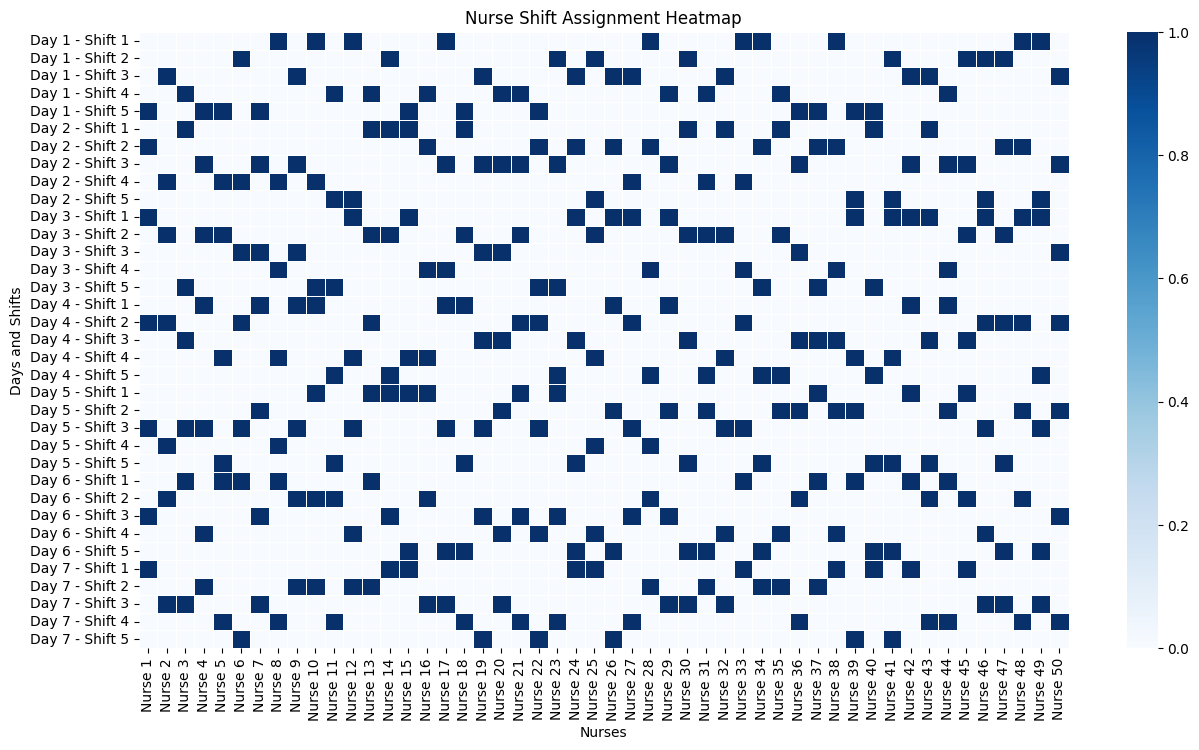

In [7]:
# Plotting the schedule - Nurse View

# Create an empty assignment matrix (Days x Shifts)
assignment_matrix = np.zeros((num_days * num_shifts, num_nurses))

# Populate the matrix with solver results
for i in all_nurses:
    for j in all_shifts:
        for d in all_days:
            if solver.Value(x[(i, j, d)]) == 1:
                assignment_matrix[d * num_shifts + j, i] = 1  # Assign a nurse

# Create a heatmap for visualization
plt.figure(figsize=(15, 8))
ax = sns.heatmap(assignment_matrix, cmap="Blues", linewidths=0.5, cbar=True, xticklabels=[f"Nurse {i+1}" for i in all_nurses], yticklabels=[f"Day {d+1} - Shift {j+1}" for d in all_days for j in all_shifts])
plt.xlabel("Nurses")
plt.ylabel("Days and Shifts")
plt.title("Nurse Shift Assignment Heatmap")
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Show the heatmap
plt.show()


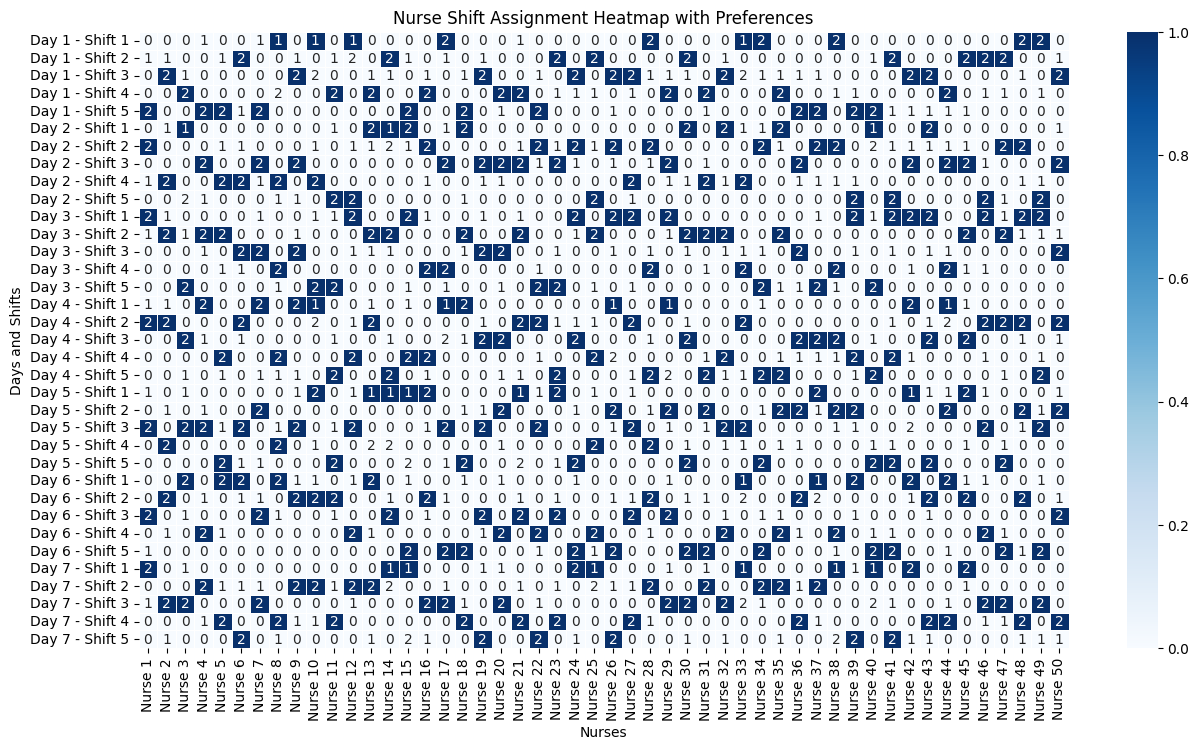

In [8]:
annot_matrix = np.empty((num_days * num_shifts, num_nurses), dtype=object)
annot_matrix.fill("")  # Default to empty string

for i in all_nurses:
    for j in all_shifts:
        for d in all_days:
            preference_value = weighted_preferences_array[i, j, d]  # Get preference level
            annot_matrix[d * num_shifts + j, i] = preference_value

# Create the heatmap
plt.figure(figsize=(15, 8))
ax = sns.heatmap(assignment_matrix, cmap="Blues", linewidths=0.5, cbar=True, 
                 xticklabels=[f"Nurse {i+1}" for i in all_nurses], 
                 yticklabels=[f"Day {d+1} - Shift {j+1}" for d in all_days for j in all_shifts],
                 annot=annot_matrix, fmt='')

# Labels and title
plt.xlabel("Nurses")
plt.ylabel("Days and Shifts")
plt.title("Nurse Shift Assignment Heatmap with Preferences")
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Show the heatmap
plt.show()

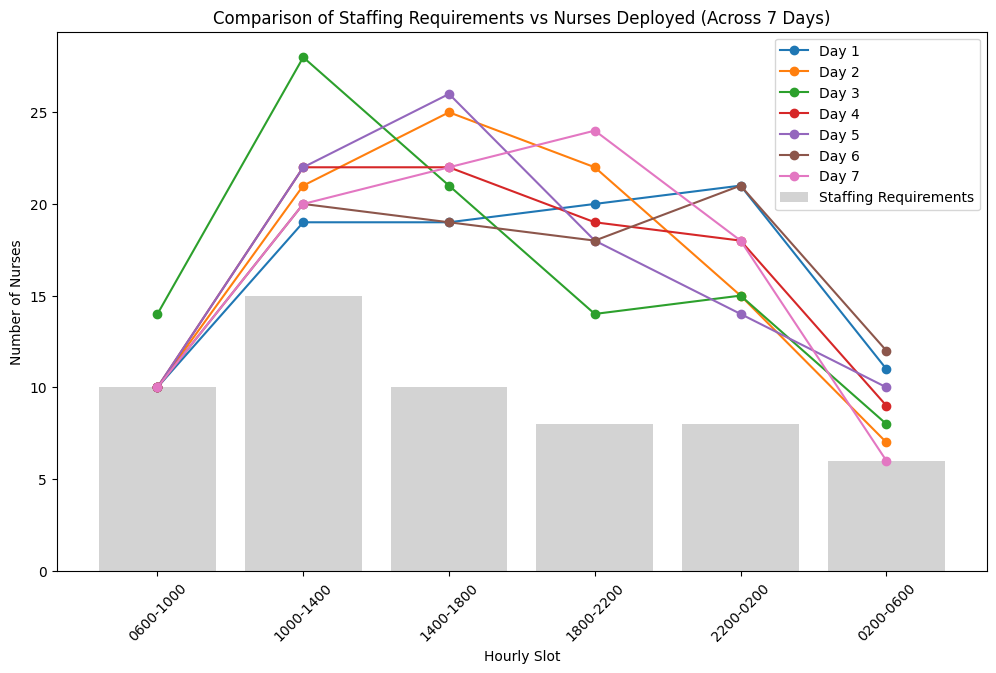

In [9]:
# Plotting the schedule - Organization View
nurses_deployed_hourly_per_day = np.zeros((num_days, len(staffing_requirements_hourly)))

# Calculate the total number of nurses deployed per hourly slot across all days
for h in range(len(staffing_requirements_hourly)):  # Iterate over hourly blocks
    for d in all_days:
        nurses_deployed_hourly_per_day[d, h] = sum(solver.Value(x[(i, j, d)]) for i in all_nurses for j in hourly_shift_map[h])

# Create the plot
plt.figure(figsize=(12, 7))

# Plot staffing requirements as a bar chart (same across all days)
plt.bar(range(len(staffing_requirements_hourly)), staffing_requirements_hourly, color='lightgray', label='Staffing Requirements')

# Plot nurses deployed per hourly slot for each day
for d in all_days:
    plt.plot(range(len(staffing_requirements_hourly)), nurses_deployed_hourly_per_day[d, :], marker='o', linestyle='-', label=f"Day {d+1}")

# Labels and title
plt.xticks(range(len(staffing_requirements_hourly)), ["0600-1000", "1000-1400", "1400-1800", "1800-2200", "2200-0200", "0200-0600"], rotation=45)
plt.xlabel("Hourly Slot")
plt.ylabel("Number of Nurses")
plt.title("Comparison of Staffing Requirements vs Nurses Deployed (Across 7 Days)")
plt.legend()

# Show the chart
plt.show()

